# DC2 Sprinkler Validation Tests for Lensed SNe

The most recent Sprinkler Truth Catalogs are in `/global/cscratch1/sd/brycek/example_truth`.

Unlensed SNe population are in: `/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db`

In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

In [2]:
import lsst

## Lensed SNe validation tests

#### Load necessary files

Unlensed SNe population files are in: `/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/` with filenames starting with `sne_cosmoDC2_v1.1.4*`

In [3]:
cosmoDC2_base = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/'

In [4]:
conn  = sqlite3.connect(os.path.join(cosmoDC2_base, 'sne_cosmoDC2_v1.1.4_MS_DDF.db'))
query = "SELECT * FROM sne_params;"

# Unlensed SNe
unlensed_sne_df = pd.read_sql_query(query,conn)

In [5]:
example_truth_folder = '/global/cscratch1/sd/brycek/example_truth'
conn = sqlite3.connect(os.path.join(example_truth_folder, 'sne_truth.db'))

# Pick only the first image of each SN so we don't have duplicate entries of the same SNe
#query = "SELECT * FROM lensed_sne WHERE image_number == 0;"
query = "SELECT * FROM lensed_sne"

# DDF unlensed SNe
sprinkled_sne_df = pd.read_sql_query(query,conn)

### Input SNe catalog

In [6]:
sn_catalog_sys = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_cosmoDC2_v1.1.4.h5', key='system')
sn_catalog_img = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_cosmoDC2_v1.1.4.h5', key='image')

In [7]:
# Checking the file to see what keys are available
with pd.HDFStore('/global/cscratch1/sd/brycek/glsne_cosmoDC2_v1.1.4.h5') as hdf:
    print(hdf.keys())

['/image', '/system', '/system/meta/values_block_2/meta', '/system/meta/values_block_1/meta', '/system/meta/values_block_0/meta']


In [8]:
sn_catalog_sys.head()

,t0,sigma,gamma,e,theta_e,theta_gamma,zs,zl,snx,sny,...,x0,lensgal_magnorm_u,lensgal_magnorm_g,lensgal_magnorm_r,lensgal_magnorm_i,lensgal_magnorm_z,lensgal_magnorm_y,lensgal_sed,lens_av,lens_rv
0,62307.945863,197.670149,0.128101,0.570391,132.165475,135.210348,0.435736,0.152485,-0.136216,0.144903,...,0.000015,18.038430,17.934849,17.876297,17.853722,17.861106,17.841955,galaxySED/Inst.80E09.04Z.spec.gz,0.0,2.0
1,62986.222880,270.972759,0.040137,0.785929,349.848750,76.941654,0.812597,0.106528,0.229110,-0.578431,...,0.000003,17.736074,17.675464,17.672657,17.652261,17.663224,17.629555,galaxySED/Burst.10E10.04Z.spec.gz,0.0,2.0
2,60175.070270,168.759862,0.145709,0.704465,246.352212,103.154255,0.377906,0.036807,0.074938,-0.416329,...,0.000019,14.632392,14.521858,14.451894,14.419520,14.379628,14.347648,galaxySED/Exp.40E09.1Z.spec.gz,0.1,4.0
3,59748.557028,132.459490,0.017375,0.598633,58.483556,133.326378,0.760426,0.034289,0.012960,0.362303,...,0.000003,16.001115,15.945108,15.954887,15.917609,15.889623,15.849615,galaxySED/Exp.40E09.04Z.spec.gz,0.0,2.0
4,61949.847395,118.022925,0.040725,0.593290,160.205181,318.665928,0.608011,0.062039,0.052200,0.120958,...,0.000006,17.650420,17.583731,17.559094,17.545495,17.549512,17.496465,galaxySED/Exp.10E10.04Z.spec.gz,0.0,2.0


In [53]:
sn_catalog_sys.columns

Index(['t0', 'sigma', 'gamma', 'e', 'theta_e', 'theta_gamma', 'zs', 'zl',
       'snx', 'sny', 'MB', 'transient_amplitude', 'sysno', 'sntype', 'ebvhost',
       'ra', 'dec', 'ebvmw', 'weight', 'host_n', 'host_ellip', 'host_reff',
       'host_theta', 'host_amplitude', 'host_type', 'host_x', 'host_y',
       'lensgal_n', 'lensgal_ellip', 'lensgal_reff', 'lensgal_theta',
       'lensgal_amplitude', 'lensgal_type', 'lensgal_x', 'lensgal_y',
       't_found', 'lensgal_mi', 'x1', 'c', 'x0', 'lensgal_magnorm_u',
       'lensgal_magnorm_g', 'lensgal_magnorm_r', 'lensgal_magnorm_i',
       'lensgal_magnorm_z', 'lensgal_magnorm_y', 'lensgal_sed', 'lens_av',
       'lens_rv'],
      dtype='object')

In [55]:
sn_catalog_img.head()

,td,x,y,mu,sysno,imno
0,0.000000,-0.756175,0.795804,1.618521,2237,0
1,11.548608,-0.216867,-0.435236,-1.057005,2237,1
2,10.111286,0.439743,-0.467307,2.794231,2237,2
3,11.585389,0.449632,0.186466,-1.024824,2237,3
0,0.000000,1.856731,-1.243184,1.709018,61544,0


### SN Population Comparison

In [10]:
unlensed_sne_df.head()

,htmid_level_6,galaxy_id,c_in,mB,t0_in,x0_in,x1_in,z_in,snid_in,snra_in,sndec_in
0,9021,10562502111,0.035201,18.516489,60772.368515,0.000617,1.477374,0.077278,MS_10199_0,66.115587,-40.866055
1,9023,10562500822,-0.086665,17.966773,63060.297448,0.001028,0.576378,0.073256,MS_10199_1,66.662435,-42.042877
2,9021,10562500735,0.037553,19.078334,62832.166508,0.000370,-0.177457,0.068469,MS_10199_2,65.212146,-41.416473
3,9021,10562502246,0.076715,19.192019,61400.008116,0.000335,-1.344205,0.080189,MS_10199_3,65.469824,-41.109646
4,9023,10562504918,-0.012653,19.388848,61342.657248,0.000278,0.474204,0.115499,MS_10199_5,65.986211,-42.086708


In [11]:
sprinkled_sne_df.head()

,index,unique_id,gal_unq_id,ra,dec,t0,t_delay,MB,magnification,x0,x1,c,host_type,redshift,dc2_sys_id,lens_cat_sys_id,image_number
0,0,1687501546316000,1687501546316000,52.848251,-27.656524,60733.028599,0.000000,-19.241234,1.511290,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,0
1,1,1687501546416001,1687501546416001,52.848257,-27.656530,60733.028599,10.692351,-19.241234,3.003103,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,1
2,2,1687501546516002,1687501546516002,52.848257,-27.656528,60733.028599,11.123024,-19.241234,-1.411856,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,2
3,3,1687501546616003,1687501546616003,52.848252,-27.656529,60733.028599,13.190929,-19.241234,-0.561527,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,3
4,4,1687502575216008,1687502575216008,52.637745,-28.040920,60531.982206,0.000000,-19.120594,2.261117,0.000086,1.0,0.0,kinney-starburst,0.188217,2001,6724378,0


## Checking distribution of SN parameters in the next few blocks

#### $x_0$ distribution

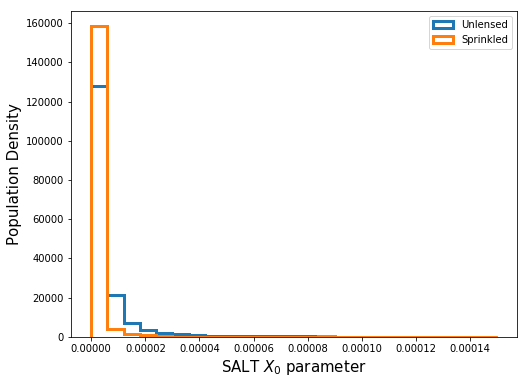

In [12]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['x0_in'], bins=25, range=(0.0, 0.00015), lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['x0'], bins=bins, lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $X_0$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### $x_1$ distribution

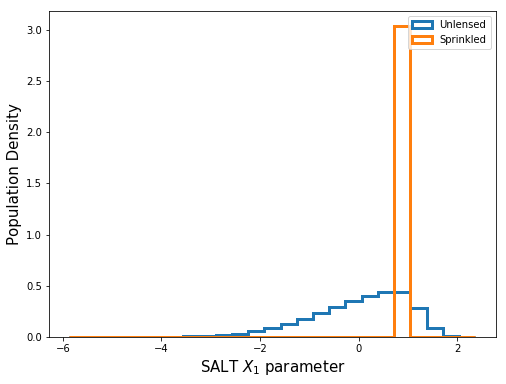

In [13]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['x1_in'], bins=25, lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['x1'], bins=bins, lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $X_1$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### $c$ distribution

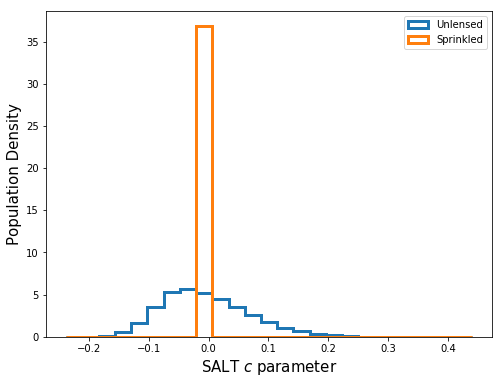

In [14]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(unlensed_sne_df['c_in'], bins=25,  lw=3, histtype='step', density=True, label='Unlensed')
_          = plt.hist(sprinkled_sne_df['c'],   bins=bins,lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('SALT $c$ parameter', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### Comparing $M_B$ of SN catalog with simulated SN

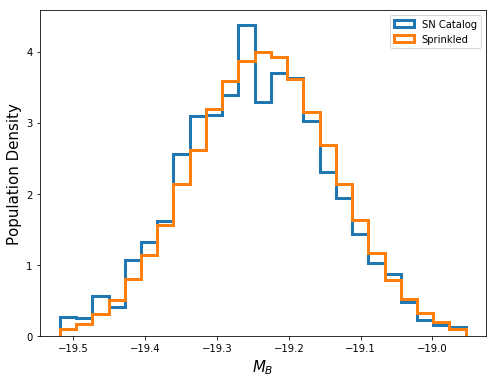

In [15]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['MB'], bins=25,  lw=3, histtype='step', density=True, label='SN Catalog')
_          = plt.hist(sn_catalog_sys['MB'],   bins=bins,lw=3, histtype='step', density=True, label='Sprinkled')
#_          = plt.hist(unlensed_sne_df['mB'],  bins=bins,lw=3, histtype='step', density=True, label='Unlensed')
plt.xlabel('$M_B$', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

### All the SNe have $x_1$ = 1 and $c=0$

In [16]:
np.where(sprinkled_sne_df['c'] != 0)

(array([], dtype=int64),)

In [17]:
np.where(sprinkled_sne_df['x1'] != 1)

(array([], dtype=int64),)

### Check distribution of angular separations, magnification, time delay

In [18]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [19]:
sprinkled_sne_df.head()

,index,unique_id,gal_unq_id,ra,dec,t0,t_delay,MB,magnification,x0,x1,c,host_type,redshift,dc2_sys_id,lens_cat_sys_id,image_number
0,0,1687501546316000,1687501546316000,52.848251,-27.656524,60733.028599,0.000000,-19.241234,1.511290,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,0
1,1,1687501546416001,1687501546416001,52.848257,-27.656530,60733.028599,10.692351,-19.241234,3.003103,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,1
2,2,1687501546516002,1687501546516002,52.848257,-27.656528,60733.028599,11.123024,-19.241234,-1.411856,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,2
3,3,1687501546616003,1687501546616003,52.848252,-27.656529,60733.028599,13.190929,-19.241234,-0.561527,0.000111,1.0,0.0,kinney-elliptical,0.175884,2000,4068871,3
4,4,1687502575216008,1687502575216008,52.637745,-28.040920,60531.982206,0.000000,-19.120594,2.261117,0.000086,1.0,0.0,kinney-starburst,0.188217,2001,6724378,0


In [20]:
sysidlist = np.unique(sprinkled_sne_df['lens_cat_sys_id'])
indices_by_system = np.array([np.where(sprinkled_sne_df['lens_cat_sys_id']==sysid)[0] for sysid in sysidlist])

In [21]:
lensedSN_coordinates = SkyCoord(ra=sprinkled_sne_df['ra']*u.degree, dec=sprinkled_sne_df['dec']*u.degree, frame='icrs')
lensedSN_sep_arcsec = []
for idxlist in indices_by_system:
    coords_this_sys = lensedSN_coordinates[idxlist]
    separations_this_sys = coords_this_sys[0].separation(coords_this_sys).to(u.arcsecond)
    lensedSN_sep_arcsec += (separations_this_sys.value).tolist()
lensedSN_sep_arcsec = np.array(lensedSN_sep_arcsec).flatten()
lensedSN_sep_arcsec_nonzero = lensedSN_sep_arcsec[np.nonzero(lensedSN_sep_arcsec>0)[0]]

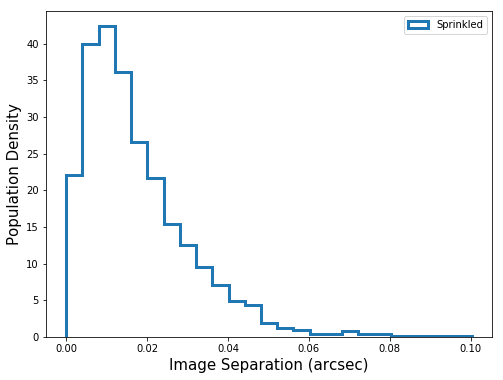

In [22]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(lensedSN_sep_arcsec_nonzero, bins=25,  lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('Image Separation (arcsec)', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

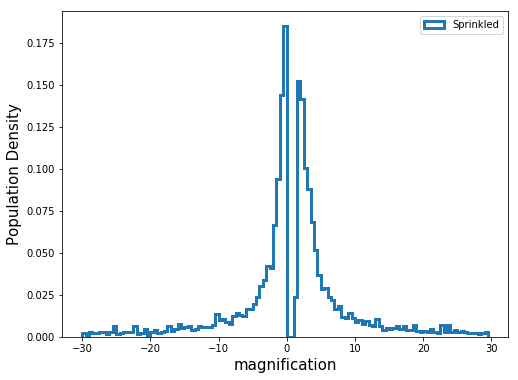

In [23]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['magnification'], bins=np.arange(-30,30,0.5),  lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('magnification', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

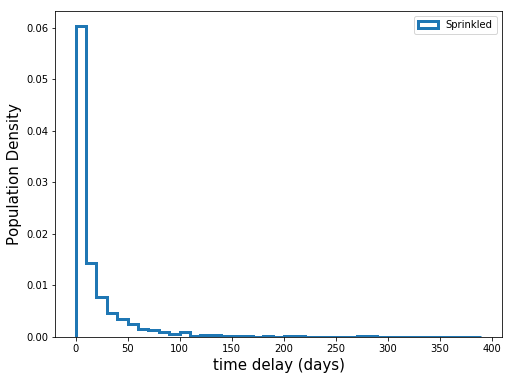

In [24]:
fig        = plt.figure(figsize=(8, 6))
n, bins, _ = plt.hist(sprinkled_sne_df['t_delay'], bins=np.arange(0.01,400,10), lw=3, histtype='step', density=True, label='Sprinkled')
plt.xlabel('time delay (days)', fontsize=15)
plt.ylabel('Population Density',   fontsize=15)
plt.legend(loc='best')

(0.03, 1000)

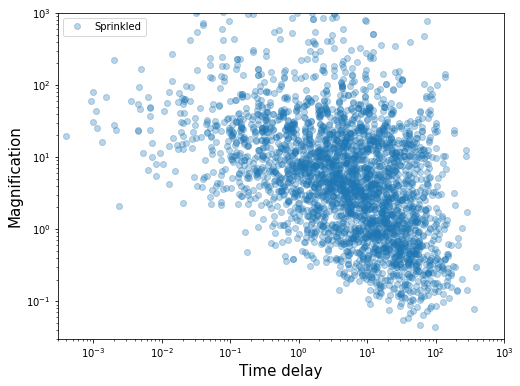

In [25]:
fig        = plt.figure(figsize=(8, 6))
#plt.plot(lensedSN_sep_arcsec, sprinkled_sne_df['magnification'],  ls=' ', marker='o', alpha=0.3, label='Sprinkled')
plt.loglog(sprinkled_sne_df['t_delay'], np.abs(sprinkled_sne_df['magnification']),  ls=' ', marker='o', alpha=0.3, label='Sprinkled')

plt.xlabel('Time delay', fontsize=15)
plt.ylabel('Magnification',   fontsize=15)
plt.legend(loc='best')

ax = plt.gca()
ax.set_xlim(3e-4, 1000)
ax.set_ylim(0.03, 1000)

## Check that the input magnifications and time delays match the sprinkled values

### Matching time-delayed SNe light-curves with the original light-curves after phase shift and de-magnification

We match the sn_catalog_img to the sprinkled_sne_df using the sysno and lens_cat_sys_id keys

In [26]:
from lsst.sims.catUtils.supernovae    import SNObject
from lsst.sims.photUtils.BandpassDict import BandpassDict

In [27]:
LSST_BPass = BandpassDict.loadTotalBandpassesFromFiles()

In [159]:
def make_sn_model_lightcurve(ra , dec , redshift, t0, x0, x1, c, StartTime, EndTime, band, n):
    '''
    StartTime: could be t0-5 days (depending on redshift)
    EndTime: could be t0+40 days
    band: LSST filter
    n: number of points wanted for the time array
    '''        
    # Setting up the supernova with the light-curve parameters from Sprinkled catalog
    sn_mod = SNObject(ra = ra, dec = dec)   
    sn_mod.set(z  = redshift,  t0 = t0, x0 = x0, x1 = x1, c  = c)

    # create a time array
    time_array = np.linspace(StartTime, EndTime, n)
    flux_array = np.array([sn_mod.catsimBandFlux(mjd, LSST_BPass[band]) for mjd in time_array])
    mag_array  = np.array([sn_mod.catsimBandMag(LSST_BPass[band], mjd, noNan=True) for mjd in time_array])
        
    return time_array, flux_array, mag_array

In [173]:
def plot_lensedSN_composite_lightcurve_model(lens_cat_sys_id, sprinkled_source_catalog, 
                                             lens_properties_catalog, plot_flux=True, **kwargs):
    """ Plot the composite light curve model of a multiply-imaged SN system, overlaying light curves  
    from all images.  Shows the model SN light curve for each image using input lensing parameters 
    (i.e. with the time  delay and magnification that we think were used to simulate the SN), and then 
    the phase-shifted and de-amplified model (after removing the time delay and amplification effects).

    FUTURE WORK NEEDED:  compare this model light curve with recovered photometry to validate that the 
    simulated lensed SNe are in fact including the time delay and amplification correctly. 

    INPUTS:
    lens_cat_sys_id  :  int; the unique identifier for this lensed SN system
    sprinkled_source_catalog : catalog (Table object) that has simulated SN properties (x1, c, t0, z, etc)
    lens_properties_catalog  : catalog (Table) that has the simulated lensing parameters (td, mu)
    """
    # Find the indices in the sprinkled_source_catalog and input_sn_catalog that belong to this lensed SN
    indices_sprinkled_cat = np.where(sprinkled_source_catalog['lens_cat_sys_id']==lens_cat_sys_id)[0]
    indices_lens_cat = np.where(lens_properties_catalog['sysno']==lens_cat_sys_id)[0]
    n_sn_images = len(indices_lens_cat)
    assert len(indices_lens_cat) == len(indices_sprinkled_cat)
    
    fig = plt.figure(figsize=[10,5])    
    axlist= [fig.add_subplot(1,n_sn_images+1,i+1) for i in range(n_sn_images)]
    axfinal = fig.add_subplot(1,n_sn_images+1, n_sn_images+1)
    
    sprinkle_subcat = sprinkled_source_catalog.iloc[indices_sprinkled_cat]
    lens_subcat = lens_properties_catalog.iloc[indices_lens_cat]

    for image_number, ax in zip(lens_subcat['imno'], axlist):
        ilens = np.where(lens_subcat['imno'] == image_number)[0][0]
        ispkl = np.where(sprinkle_subcat['image_number'] == image_number)[0][0]
 
        deltat_sprinkle = sprinkle_subcat['t_delay'].iloc[ispkl]
        deltat_lens = lens_subcat['td'].iloc[ilens]

        magnification_sprinkle = sprinkle_subcat['magnification'].iloc[ispkl]
        magnification_lens = lens_subcat['mu'].iloc[ilens]
    
        mjd, flux, mag = make_sn_model_lightcurve(
            sprinkle_subcat['ra'].iloc[ispkl], 
            sprinkle_subcat['dec'].iloc[ispkl] , 
            sprinkle_subcat['redshift'].iloc[ispkl], 
            sprinkle_subcat['t0'].iloc[ispkl] + deltat_sprinkle, 
            sprinkle_subcat['x0'].iloc[ispkl], 
            sprinkle_subcat['x1'].iloc[ispkl], 
            sprinkle_subcat['c'].iloc[ispkl], 
            sprinkle_subcat['t0'].iloc[ispkl]-5, 
            sprinkle_subcat['t0'].iloc[ispkl]+40, 
            'r', 100)
        if plot_flux:
            ax.plot(mjd, flux * np.abs(magnification_sprinkle), **kwargs)
            axfinal.plot( mjd-deltat_lens, flux * magnification_sprinkle / magnification_lens, label='Im{:d}'.format(image_number), **kwargs)
        else:
            ax.plot(mjd, mag - 2.5*np.log10(np.abs(magnification_sprinkle)), **kwargs)
            axfinal.plot( mjd-deltat_lens, mag -2.5*np.log10(np.abs(magnification_sprinkle / magnification_lens)), label='Im{:d}'.format(image_number), ls='--')
            if not ax.yaxis_inverted():
                ax.invert_yaxis()
            if not axfinal.yaxis_inverted():
                axfinal.invert_yaxis()

        if image_number==0 : 
            ax.set_title('Lens System {:d}  Image {:d}'.format(lens_cat_sys_id, image_number))       
        else: 
            ax.set_title('Image {:d}'.format(image_number))            
        ax.text(0.95,0.95, r"$\Delta$t= {:.2f} (lens cat)".format(deltat_lens), ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95,0.85, r"$\Delta$t= {:.2f} (spkl cat)".format(deltat_sprinkle), ha='right', va='top', transform=ax.transAxes)
    axfinal.legend()
    axfinal.set_title("Composite LC (de-lensed)")

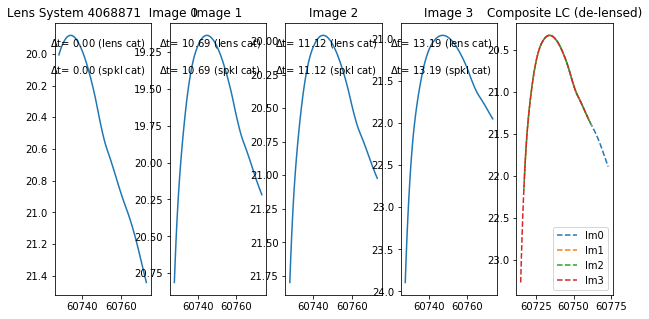

In [174]:
lens_sysid = 4068871
#lens_sysid = 6724378
lens_properties_catalog = sn_catalog_img
sprinkled_source_catalog = sprinkled_sne_df
plot_lensedSN_composite_lightcurve_model(lens_sysid, sprinkled_source_catalog, sn_catalog_img, plot_flux=False)